# Adaptive Error Correction in MLDA

### Intro
This notebook (along with the utility code within the `./mlda` folder) is designed to demonstrate the adaptive error correction feature of the Multi-Level Delayed Acceptance MCMC algorithm (MLDA) in PyMC3. The MLDA algorithm was proposed in [1], while the error correction feature has been taken from [2]. 

The MLDA sampler can be more efficient than other MCMC samplers when dealing with computationally intensive problems where we have access not only to the desired (fine) posterior distribution but also to a set of approximate (coarse) posteriors of decreasing accuracy and decreasing computational cost (for more details look at the notebook `./MLDA_multilevel_groundwater_flow.ipynb`).

For more details about the MLDA sampler and the way it should be used and parameterised, the user can refer to the notebook above, as well as the docstrings within the python code (the implementation is under `pymc3/pymc3/step_methods/metropolis.py`). A version of this code in `.py` form can be found under `./mlda`.

Please note that the MLDA sampler is new in pymc3. The user should be extra critical about the results and report any problems as issues in the pymc3's github repository.

The notebook results shown below were generated on a MacBook Pro with a 2.6 GHz 6-core Intel Core i7, 32 GB DDR4 and macOS 10.15.5.

### Adaptive Error Correction
The idea of Adaptive Error Correction (AEC) is to estimate the bias and variance of the forward-model error between successive levels. We then use those estimates to correct for the error. This helps smooth the differences between levels and thus allows more successful proposals from a level to the one above. Using the technique should improve ESS/sec on the fine level. 

For more details about the method, please refer to section 3.2 of [2]. We have implemented Algorithm 4 without the adaptation in the base chain (although this will be added in the future). Also, we do the recursive mean and covariance calculation not according to equation (8) of [2] but according to equation (3) of [3] (which has been tested to work correctly in simulations).

The method assumes that the error between successive forward model outputs is normal-distributed and that the error introduced by the modelling process is also normal. This allows the method to work as described in the paper. In order to use AEC with a non-normal model, modification to the MCMC internals and the model description template would be needed. 

### The model and PDE solver details
Please refer to `./MLDA_multilevel_groundwater_flow.ipynb` for more details.

### Dependencies
The code has been developed and tested with Python 3.6. You will need to have pymc3 installed and also install [FEniCS](https://fenicsproject.org/) for your system.
  

### References
[1] Dodwell, Tim & Ketelsen, Chris & Scheichl, Robert & Teckentrup, Aretha. (2019). Multilevel Markov Chain Monte Carlo. SIAM Review. 61. 509-545. https://doi.org/10.1137/19M126966X

[2] Cui, Tiangang & Fox, Colin & O'Sullivan, Michael. (2012). Adaptive Error Modelling in MCMC Sampling for Large Scale Inverse Problems.

[3] Haario, Heikki; Saksman, Eero; Tamminen, Johanna. An adaptive Metropolis algorithm. Bernoulli 7 (2001), no. 2, 223--242. https://projecteuclid.org/euclid.bj/1080222083

### Import modules

In [31]:
# Import groundwater flow model utils
import sys
sys.path.insert(1, 'mlda/')

In [32]:
import os
import numpy as np
import time
import pymc3 as pm
import theano.tensor as tt
from Model import Model, model_wrapper, project_eigenpairs
from itertools import product
import matplotlib.pyplot as plt
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Set environmental variable
%matplotlib inline

### Set parameters

In [33]:
# Set the resolution of the multi-level models (from coarsest to finest)
# This is a list of different model resolutions. Each
# resolution added to the list will add one level to the multi-level
# inference. Each element is a tuple (x,y) where x, y are the number of 
# points in each dimension. For example, here we set resolutions = 
# [(30, 30), (120, 120)] which creates a coarse, cheap 30x30 model and 
# a fine, expensive 120x120 model.
resolutions = [(4, 4), (20, 20), (120, 120)]

# Set random field parameters
field_mean = 0
field_stdev = 1
lamb_cov = 0.1

# Set the number of unknown parameters (i.e. dimension of theta in posterior)
nparam = 3

# Number of draws from the distribution
ndraws = 10000

# Number of burn-in samples
nburn = 5000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100
discard_tuning = True

# Number of independent chains
nchains = 4

# Subsampling rate for MLDA
nsub = 5

# Do blocked/compounds sampling in Metropolis and MLDA 
# Note: This choice applies only to the coarsest level in MLDA 
# (where a Metropolis sampler is used), all other levels use block sampling
blocked = False

# Set the sigma for inference
sigma = 0.01

# Data generation seed
data_seed = 12345

# Sampling seed
sampling_seed = 12345

# Datapoints list
points_list = [0.1, 0.3, 0.5, 0.7, 0.9]

### Define the forward model using a Theano Op
Inside the Op, we make use of the Data class of PyMC3 to pass the forward model output to the PyMC3 model (stored in variable `model_output`). Doing this gives the MLDA sampler access to the model output. The user needs to include this storage operation to `model_output` in the Op if they want to use adaptive error correction. 

In [34]:
class ForwardModel(tt.Op):
    """
    Theano Op that wraps the forward model computation,
    necessary to pass "black-box" fenics code into pymc3.    
    """

    # Specify what type of object will be passed and returned to the Op when it is
    # called. In our case we will be passing it a vector of values (the parameters
    # that define our model) and returning a vector of model outputs
    itypes = [tt.dvector]  # expects a vector of parameter values (theta)
    otypes = [tt.dvector]  # outputs a vector of model outputs

    def __init__(self, my_model, x, pymc3_model):
        """
        Initialise the Op with various things that our forward model function
        requires.

        Parameters
        ----------
        my_model:
            A Model object (defined in file model.py) that contains the parameters
            and functions of our model.
        x:
            The dependent variable (aka 'x') that our model requires. This is
            the datapoints in this example.
        pymc3:
            The PyMC3 model being used.
        """
        # add inputs as class attributes
        self.my_model = my_model
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta = inputs[0]  # this will contain my variables

        # call the forward model function
        temp = model_wrapper(self.my_model, theta, self.x)
        
        # NOTE: These two lines need to be included in the perform() function is you want to use AEC
        # save the forward model output to a data variable (`model_output`) within the pymc3 model
        # this allows PyMC3 to access the value during sampling
        self.pymc3_model.model_output.set_value(temp)
            
        # write to output
        outputs[0][0] = temp


### Instantiate Model objects and data

In [35]:
# Note this can take several minutes for large resolutions
my_models = []
for r in resolutions:
    my_models.append(Model(r, field_mean, field_stdev, nparam, lamb_cov))

# Project eignevactors from fine model to all coarse models
for i in range(len(my_models[:-1])):
    project_eigenpairs(my_models[-1], my_models[i])

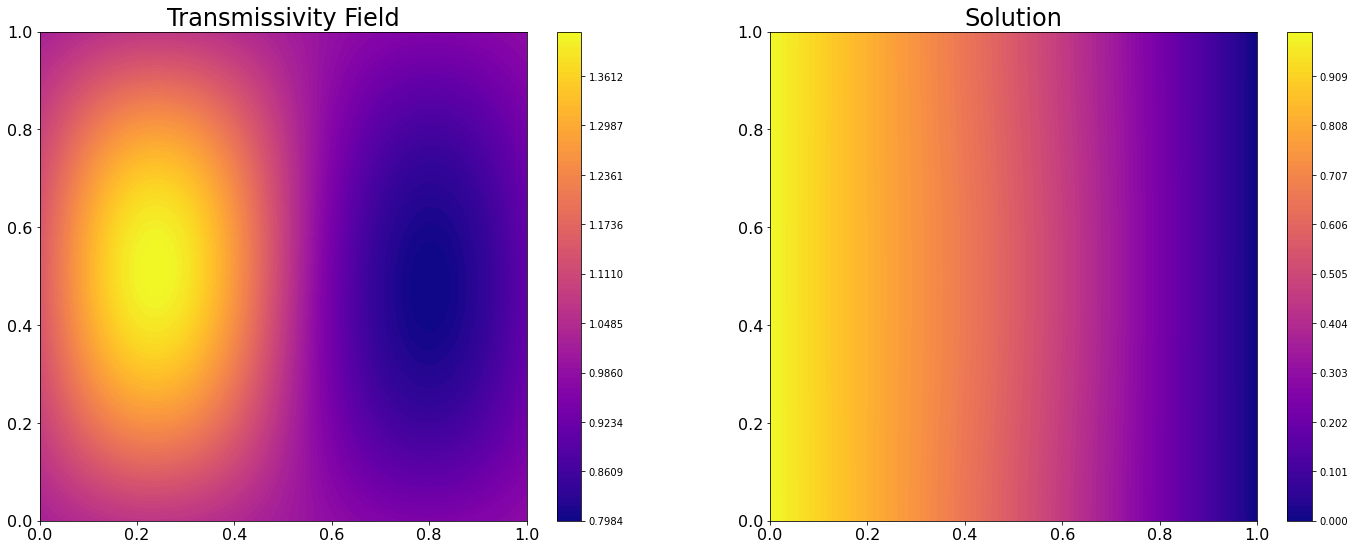

In [36]:
# Solve finest model as a test and plot transmissivity field and solution
np.random.seed(data_seed)
my_models[-1].solve()
my_models[-1].plot(lognormal=False)

# Save true parameters of finest model
true_parameters = my_models[-1].random_process.parameters

In [37]:
# Define the sampling points.
x_data = y_data = np.array(points_list)
datapoints = np.array(list(product(x_data, y_data)))

# Get data from the sampling points and perturb it with some noise.
noise = np.random.normal(0, 0.001, len(datapoints))

# Generate data from the finest model for use in pymc3 inference - these data are used in all levels
data = model_wrapper(my_models[-1], true_parameters, datapoints) + noise

# Create covariance matrix of normal error - it is a diagonal matrix
s = np.identity(len(data))
np.fill_diagonal(s, sigma**2)

### Instantiate LogLik objects

In [38]:
# create Theano Ops to wrap forward models of all model levels and store them in list
mout = []

### Construct pymc3 model objects for coarse models

In [39]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # mu_B and Sigma_B are the mean and covariance of the bias
        # between this forward model and the model one level below. The bias is due
        # to different levels of coarseness, i.e. resolutions.
        # Both are initialised with zeros.
        # These will be updated in each iteration of this level's chain
        mu_B = pm.Data('mu_B', np.zeros(len(data)))
        Sigma_B = pm.Data('Sigma_B', np.zeros((len(data), len(data))))
        
        # This will be used to store the output of the forward model produced by the Op
        # The user needs to save the model output to this variable inside the 
        # perform() method of the Op
        model_output = pm.Data('model_output', np.zeros(len(data)))

        # Sigma_e is the covariance of the assumed error 'e' in the model.
        # This error is due to measurement noise/bias vs. the real world
        Sigma_e = pm.Data('Sigma_e', s)

        # uniform priors on unknown parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # Here we instatiate a ForwardModel and pass the model as argument
        mout.append(ForwardModel(my_models[j], datapoints, model))
        
        # Output is an intermediate variable for convenience
        #output = pm.Potential('output', mout[j](theta))

        # The distribution of the error 'e' (assumed error of the forward model)
        # This is multi-variate normal where:
        # - the mean is equal to the forward model output plus the bias correction term mu_B
        # - the covariance is equal to the forward model covariance Sigma_e plus the bias correction term Sigma_B
        # This creates the likelihood of the model given the observed data
        pm.MvNormal('e', mu=mout[j](theta) + mu_B, cov=Sigma_e + Sigma_B, observed=data)

    coarse_models.append(model)

### Perform inference using MLDA (without AEC)
Here we sample from the posterior using MLDA without AEC

In [40]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.
method_names = []
traces = []
runtimes = []
acc = []
ess = []
ess_n = []
performances = []

with pm.Model() as fine_model:
    # This will be used to store the output of the forward model produced by the Op
    # The user needs to save the model output to this variable inside the 
    # perform() method of the Op
    model_output = pm.Data('model_output', np.zeros(len(data)))

    # Sigma_e is the covariance of the assumed error 'e' in the model.
    # This error is due to measurement noise/bias vs. the real world
    Sigma_e = pm.Data('Sigma_e', s)

    # uniform priors on unknown parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # Here we instatiate a ForwardModel and pass the model as argument
    mout.append(ForwardModel(my_models[-1], datapoints, fine_model))
    
    # Output is an intermediate variable for convenience
    #output = pm.Potential('output', mout[-1](theta))

    # The distribution of the error 'e' (assumed error of the forward model)
    pm.MvNormal('e', mu=mout[-1](theta), cov=Sigma_e, observed=data)

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list
    step_mlda_without = pm.MLDA(subsampling_rate=nsub, coarse_models=coarse_models,
                                tune=tune, tune_interval=tune_interval, base_blocked=blocked,
                                adaptive_error_correction=False)    

    # Inference!    
    # MLDA without adaptive error correction
    t_start = time.time()
    method_names.append("MLDA_without_aec")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_without,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                           cores=1))
    runtimes.append(time.time() - t_start)

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1060: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


The number of effective samples is smaller than 10% for some parameters.


### Instantiate LogLik objects

In [41]:
# create Theano Ops to wrap forward models of all model levels and store them in list
mout = []

### Construct pymc3 model objects for coarse models

In [42]:
# Set up models in pymc3 for each level - excluding finest model level
coarse_models = []
for j in range(len(my_models) - 1):
    with pm.Model() as model:
        # mu_B and Sigma_B are the mean and covariance of the bias
        # between this forward model and the model one level below. The bias is due
        # to different levels of coarseness, i.e. resolutions.
        # Both are initialised with zeros.
        # These will be updated in each iteration of this level's chain
        mu_B = pm.Data('mu_B', np.zeros(len(data)))
        Sigma_B = pm.Data('Sigma_B', np.zeros((len(data), len(data))))
        
        # This will be used to store the output of the forward model produced by the Op
        # The user needs to save the model output to this variable inside the 
        # perform() method of the Op
        model_output = pm.Data('model_output', np.zeros(len(data)))

        # Sigma_e is the covariance of the assumed error 'e' in the model.
        # This error is due to measurement noise/bias vs. the real world
        Sigma_e = pm.Data('Sigma_e', s)

        # uniform priors on unknown parameters
        parameters = []
        for i in range(nparam):
            parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable(parameters)

        # Here we instatiate a ForwardModel and pass the model as argument
        mout.append(ForwardModel(my_models[j], datapoints, model))
        
        # Output is an intermediate variable for convenience
        #output = pm.Potential('output', mout[j](theta))

        # The distribution of the error 'e' (assumed error of the forward model)
        # This is multi-variate normal where:
        # - the mean is equal to the forward model output plus the bias correction term mu_B
        # - the covariance is equal to the forward model covariance Sigma_e plus the bias correction term Sigma_B
        # This creates the likelihood of the model given the observed data
        pm.MvNormal('e', mu=mout[j](theta) + mu_B, cov=Sigma_e + Sigma_B, observed=data)

    coarse_models.append(model)

### Perform inference using MLDA with AEC
Here we sample from the posterior using MLDA with AEC

In [43]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm
# and passing the coarse_models list created above.

with pm.Model() as fine_model:
    # This will be used to store the output of the forward model produced by the Op
    # The user needs to save the model output to this variable inside the 
    # perform() method of the Op
    model_output = pm.Data('model_output', np.zeros(len(data)))

    # Sigma_e is the covariance of the assumed error 'e' in the model.
    # This error is due to measurement noise/bias vs. the real world
    Sigma_e = pm.Data('Sigma_e', s)

    # uniform priors on unknown parameters
    parameters = []
    for i in range(nparam):
        parameters.append(pm.Uniform('theta_' + str(i), lower=-3., upper=3.))

    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable(parameters)

    # Here we instatiate a ForwardModel and pass the model as argument
    mout.append(ForwardModel(my_models[-1], datapoints, fine_model))
    
    # Output is an intermediate variable for convenience
    #output = pm.Potential('output', mout[-1](theta))

    # The distribution of the error 'e' (assumed error of the forward model)
    pm.MvNormal('e', mu=mout[-1](theta), cov=Sigma_e, observed=data)

    # Initialise an MLDA step method object, passing the subsampling rate and
    # coarse models list    
    step_mlda_with = pm.MLDA(subsampling_rate=nsub, coarse_models=coarse_models,
                             tune=tune, tune_interval=tune_interval, base_blocked=blocked,
                             adaptive_error_correction=True)

    # Inference!    
    # MLDA with adaptive error correction
    t_start = time.time()
    method_names.append("MLDA_with_aec")
    traces.append(pm.sample(draws=ndraws, step=step_mlda_with,
                            chains=nchains, tune=nburn,
                            discard_tuned_samples=discard_tuning,
                            random_seed=sampling_seed,
                           cores=1))
    runtimes.append(time.time() - t_start)

/Users/gmingas/projects/pymc3/pymc3/step_methods/metropolis.py:1060: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


### Print performance metrics

In [44]:
import arviz as ar

for i, trace in enumerate(traces):
    acc.append(trace.get_sampler_stats('accepted').mean())
    ess.append(np.array(ar.ess(trace).to_array()))
    ess_n.append(ess[i] / len(trace) / trace.nchains)
    performances.append(ess[i] / runtimes[i])
    print(f'\nSampler {method_names[i]}: {len(trace)} drawn samples in each of '
          f'{trace.nchains} chains.'
          f'\nRuntime: {runtimes[i]} seconds'
          f'\nAcceptance rate: {acc[i]}'
          f'\nESS list: {ess[i]}'
          f'\nNormalised ESS list: {ess_n[i]}'
          f'\nESS/sec: {performances[i]}')

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_without_aec: 10000 drawn samples in each of 4 chains.
Runtime: 11728.477172136307 seconds
Acceptance rate: 0.21195
ESS list: [2920.7243992  3029.22809124 2660.69838365]
Normalised ESS list: [0.07301811 0.0757307  0.06651746]
ESS/sec: [0.24902844 0.25827974 0.22685796]


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_with_aec: 10000 drawn samples in each of 4 chains.
Runtime: 16101.012372016907 seconds
Acceptance rate: 0.940575
ESS list: [32478.73960721 36013.55438084 34831.16395755]
Normalised ESS list: [0.81196849 0.90033886 0.8707791 ]
ESS/sec: [2.01718618 2.23672609 2.1632903 ]


In [45]:
print(f"\nMLDA-AEC vs. MLDA performance speedup in all dimensions (performance measured by ES/sec):\n{np.array(performances[1]) / np.array(performances[0])}")


MLDA-AEC vs. MLDA performance speedup in all dimensions (performance measured by ES/sec):
[8.10022406 8.66009097 9.53588017]


### Show stats summary

In [46]:
print(f"\nDetailed summaries and plots:\nTrue parameters: {true_parameters}")
for i, trace in enumerate(traces):
    print(f"\nSampler {method_names[i]}:\n", pm.stats.summary(trace))


Detailed summaries and plots:
True parameters: [-0.20470766  0.47894334 -0.51943872]


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_without_aec:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
theta_0 -0.194  0.167  -0.504    0.117      0.003    0.002    2908.0  2908.0   
theta_1  0.451  0.156   0.173    0.762      0.003    0.002    3040.0  3040.0   
theta_2 -0.554  0.156  -0.860   -0.274      0.003    0.002    2676.0  2676.0   

         ess_bulk  ess_tail  r_hat  
theta_0    2921.0    3644.0    1.0  
theta_1    3029.0    4479.0    1.0  
theta_2    2661.0    4129.0    1.0  


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,



Sampler MLDA_with_aec:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
theta_0 -0.190  0.166  -0.498    0.123      0.001    0.001   32484.0  32484.0   
theta_1  0.450  0.155   0.157    0.739      0.001    0.001   36022.0  36022.0   
theta_2 -0.556  0.154  -0.838   -0.265      0.001    0.001   34828.0  34828.0   

         ess_bulk  ess_tail  r_hat  
theta_0   32479.0   35947.0    1.0  
theta_1   36014.0   36981.0    1.0  
theta_2   34831.0   35930.0    1.0  


### Show traceplots

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


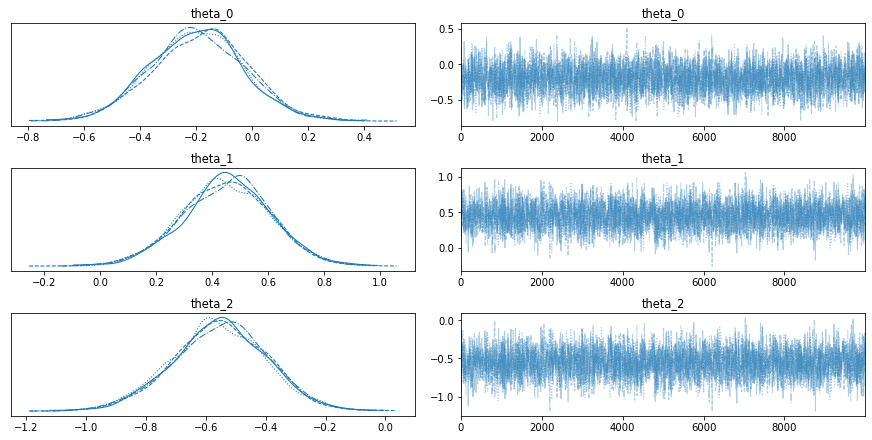

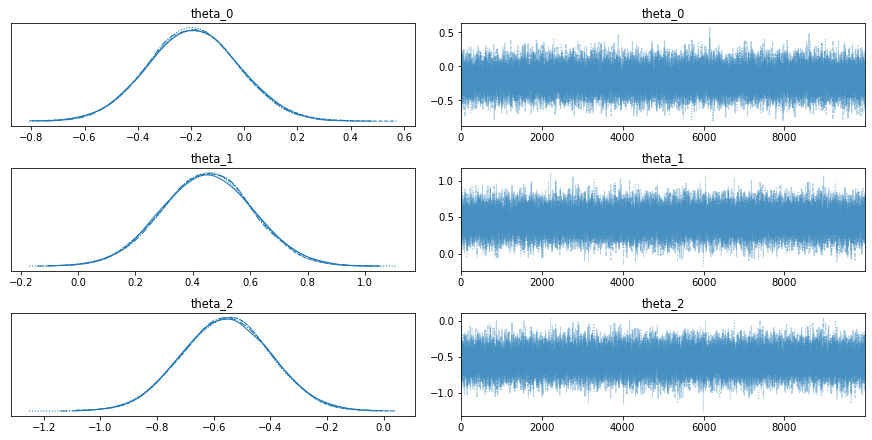

In [47]:
# Print true theta values and pymc3 sampling summary
for i, trace in enumerate(traces):
    pm.plots.traceplot(trace)
